Use this utlity to update the correlations between asset classes in universe/asset-prices.csv

input files:
- asset-classes-2-etf.csv: mapping of asset classes to a representative ETF to use for calculating correlations
- asset-classes-in.csv: asset pairs for which to calculate correlations

output files:
- symbols-cache/'symbol'.csv: timeseries for each symbol 
- symbols-timeseries.csv: compiled timeseries for symbols
- asset-classes.csv: asset class pairs with correlations

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import brownbear as bb

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [3]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Globals

In [4]:
# Set refresh_timeseries=True to download timeseries.  Otherwise /symbol-cache is used.
refresh_timeseries = True

In [5]:
# asset2etf dict provides a mapping from the asset name to a representative ETF.
asset2etf = pd.read_csv('asset-classes-2-etf.csv', skip_blank_lines=True, comment='#')
asset2etf = asset2etf.set_index(['Asset Class'])
asset2etf = asset2etf['ETF'].to_dict()
asset2etf

{'US Stocks': 'VTSMX',
 'Global Stocks': 'VXUS',
 'US Bonds': 'AGG',
 'Global Bonds': 'BNDX',
 'Cash Equivalents': 'BIL',
 'Real Estate': 'VNQ',
 'Commodities': 'DBC',
 'Currencies': 'UUP',
 'Managed Futures': 'CTA',
 'Balanced': 'AOM',
 'Risk-Free Asset': 'BIL',
 'US Stocks:Large Cap': 'SPY',
 'US Stocks:Mid Cap': 'MDY',
 'US Stocks:Small Cap': 'IWM',
 'US Stocks:Growth': 'QQQ',
 'US Stocks:Growth and Income': 'VOO',
 'US Stocks:Value': 'IWD',
 'US Stocks:Total Stock Market': 'VTI',
 'US Stocks:Materials': 'XLB',
 'US Stocks:Communication Services': 'XLC',
 'US Stocks:Energy': 'XLE',
 'US Stocks:Financials': 'XLF',
 'US Stocks:Industrials': 'XLI',
 'US Stocks:Technology': 'XLK',
 'US Stocks:Consumer Staples': 'XLP',
 'US Stocks:Real Estate': 'XLRE',
 'US Stocks:Utilities': 'XLU',
 'US Stocks:Healthcare': 'XLV',
 'US Stocks:Consumer Discretionary': 'XLY',
 'Global Stocks:Asia': 'VPL',
 'Global Stocks:Developed Markets': 'EFA',
 'Global Stocks:Emerging Markets': 'EEM',
 'Global Stocks:E

In [6]:
symbols = set(asset2etf.values())

In [7]:
bb.fetch_timeseries(symbols, refresh=refresh_timeseries)
bb.compile_timeseries(symbols)

VPL VXUS BWX PPLT SPY FXB XLC UUP XLF EBND XLP PFF AOK MDY LQD EEM IBND UGA DBB AOM XLB IYR BIL AGG JNK DBE DBP BNDX BWZ GLD CORN FXC XLE XLI JPST FXE TLT USO IWM IEI XLV EFA SLV FXF FXA VOO PALL TIP IEUR CYB IWD XLU AOA VTSMX UNG AOR DBA VTI VNQ DBC QQQ CANE CPER CTA FXY XLRE XLK XLY 


In [8]:
df = pd.read_csv('symbols-timeseries.csv', skip_blank_lines=True, comment='#')
df.set_index("Date", inplace=True)
df

,VPL,VXUS,BWX,PPLT,SPY,FXB,XLC,UUP,XLF,EBND,...,VNQ,DBC,QQQ,CANE,CPER,CTA,FXY,XLRE,XLK,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,43.04,35.78,25.04,116.57,172.59,141.87,NaN,20.91,16.59,19.99,...,55.20,15.93,95.27,11.59,19.02,NaN,80.72,NaN,36.44,63.95
2015-01-05,42.50,34.99,24.98,117.60,169.48,141.13,NaN,20.95,16.24,19.80,...,55.50,15.70,93.87,11.45,19.02,NaN,81.31,NaN,35.88,62.73
2015-01-06,42.06,34.72,25.06,118.54,167.88,140.18,NaN,20.99,15.99,19.72,...,56.05,15.56,92.61,11.86,18.74,NaN,82.11,NaN,35.45,62.10
2015-01-07,42.61,35.13,24.99,118.32,169.97,139.76,NaN,21.07,16.16,19.97,...,56.91,15.46,93.80,11.71,18.74,NaN,81.66,NaN,35.75,63.08
2015-01-08,43.13,35.58,24.95,118.11,172.99,139.54,NaN,21.16,16.40,20.04,...,57.13,15.52,95.60,12.07,18.68,NaN,81.32,NaN,36.54,64.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,71.49,59.53,21.49,85.85,601.34,120.60,99.04,29.31,49.11,19.62,...,89.65,20.98,529.60,11.41,25.89,27.70,58.40,40.87,240.69,233.60
2024-12-27,71.64,59.40,21.41,84.22,595.01,121.07,98.16,29.26,48.75,19.60,...,88.75,21.08,522.56,11.44,25.79,27.48,58.46,40.54,237.49,229.74
2024-12-30,71.16,59.00,21.46,82.66,588.22,120.80,97.13,29.29,48.28,19.58,...,88.31,21.27,515.61,11.38,25.63,27.77,58.81,40.35,234.47,226.05


np.float64(0.6969859942462039)

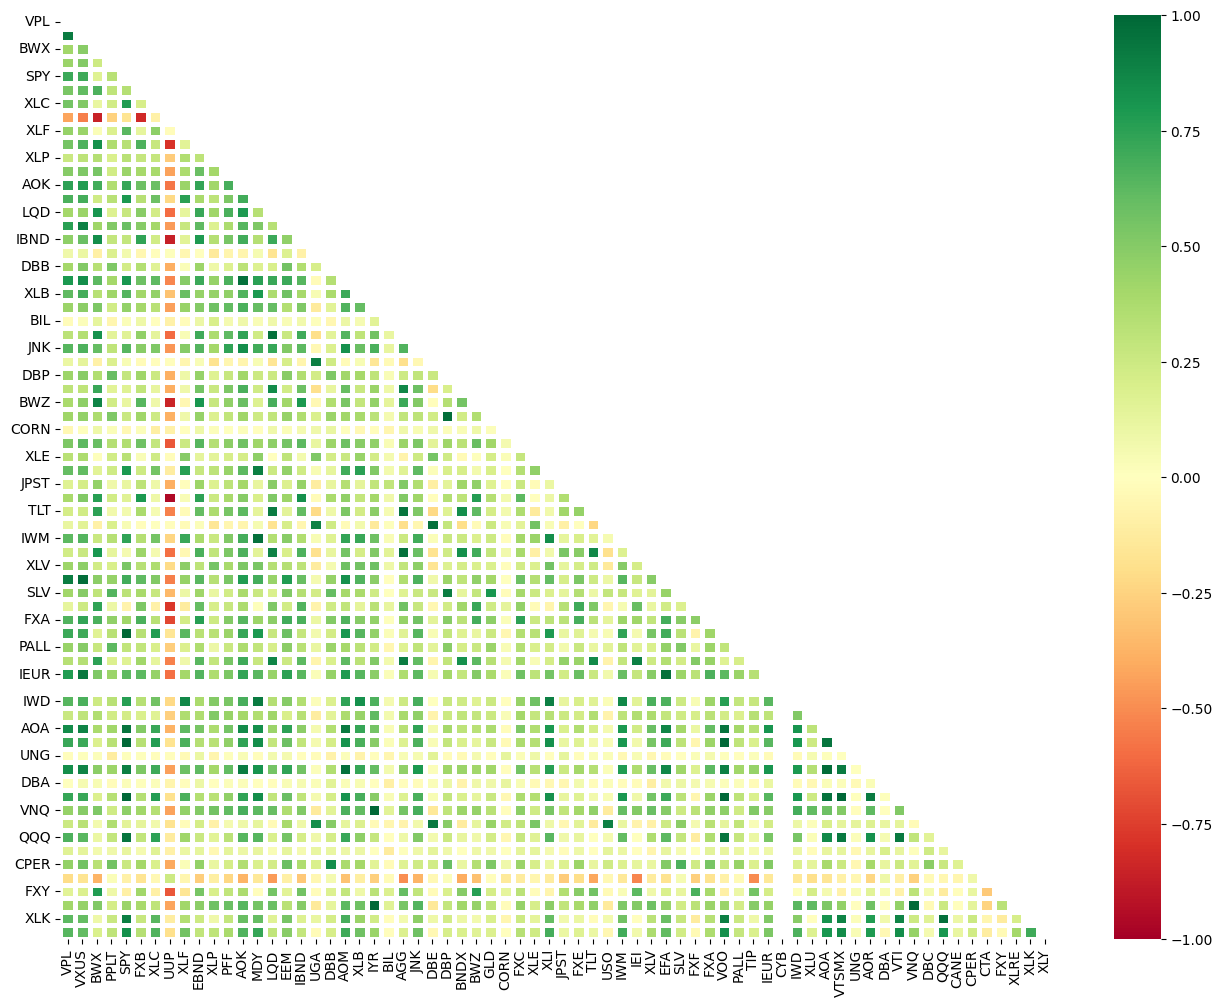

In [9]:
corr_map = bb.correlation_map(df, method='log', days=bb.TRADING_DAYS_PER_YEAR)
# Sample correlation value.
corr_map['SPY']['VXUS']

In [10]:
# Read asset-classes-in.csv
lines = []
with open('asset-classes-in.csv', 'r') as f:
    lines = [line.strip() for line in f]
#lines

In [11]:
# Calculate the pair correlations between the assets and write the resuls to a list.
out = []
for line in lines:
    # Copy empty and comment lines.
    if not line or line.startswith('#'):
        out.append(line)
        continue
    # Split line by comma delimiter; strip the fields.
    fields = line.split(',')
    fields = [field.strip() for field in fields]
    assetA = fields[0].strip('\"')
    assetB = fields[1].strip('\"')
    # copy same asset lines and header
    if assetA == assetB or assetA == 'Asset Class A':
        out.append(line)
        continue
    # Use asset2etf to get a representative ETF for the asset,
    # then calculate the correlation.  The ETF pair correlation is
    # a proxy for the correlation of an asset pair.
    etfA = asset2etf[assetA]
    etfB = asset2etf[assetB]
    corrAB = corr_map.loc[etfA, etfB]
    out.append(f'"{assetA}","{assetB}","{corrAB:0.2f}"')   

In [12]:
# Write out asset-classes.csv
with open('asset-classes.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')

In [13]:
# Sample symbol.
symbol = 'SPY'

In [14]:
annual_returns = bb.annualized_returns(df, timeperiod='daily', years=1)
annual_returns[symbol]

np.float64(25.280735021035028)

In [15]:
# Calculate 1 month, 3 months, 1 year, 3 year, and 5 year annualized returns.
annual_returns_1mo = bb.annualized_returns(df, timeperiod='daily', years=1/12)
annual_returns_3mo = bb.annualized_returns(df, timeperiod='daily', years=3/12)
annual_returns_1yr = bb.annualized_returns(df, timeperiod='daily', years=1)
annual_returns_3yr = bb.annualized_returns(df, timeperiod='daily', years=3)
annual_returns_5yr = bb.annualized_returns(df, timeperiod='daily', years=5)

In [16]:
# Calculate 20 day annualized volatility.
daily_returns = df.pct_change(fill_method=None)
years = bb.TRADING_DAYS_PER_MONTH / bb.TRADING_DAYS_PER_YEAR
vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years)
vola[symbol]

np.float64(0.142652994848746)

In [17]:
# Calculate 20 day annualized downside volatility.
ds_vola = bb.annualized_standard_deviation(daily_returns, timeperiod='daily', years=years, downside=True)
ds_vola[symbol]

np.float64(0.10828700749646404)

In [18]:
# Resample df on a monthly basis.
df.index = pd.to_datetime(df.index)
monthly = df.resample('ME').ffill()
bb.print_full(monthly[symbol])

Date
2015-01-31   167.57
2015-02-28   176.99
2015-03-31   174.21
2015-04-30   175.92
2015-05-31   178.18
2015-06-30   174.56
2015-07-31   178.51
2015-08-31   167.63
2015-09-30   163.35
2015-10-31   177.24
2015-11-30   177.89
2015-12-31   174.82
2016-01-31   166.11
2016-02-29   165.98
2016-03-31   177.14
2016-04-30   177.84
2016-05-31   180.86
2016-06-30   181.49
2016-07-31   188.11
2016-08-31   188.34
2016-09-30   188.35
2016-10-31   185.08
2016-11-30   191.90
2016-12-31   195.79
2017-01-31   199.29
2017-02-28   207.13
2017-03-31   207.38
2017-04-30   209.44
2017-05-31   212.40
2017-06-30   213.75
2017-07-31   218.15
2017-08-31   218.78
2017-09-30   223.19
2017-10-31   228.45
2017-11-30   235.43
2017-12-31   238.29
2018-01-31   251.72
2018-02-28   242.57
2018-03-31   235.92
2018-04-30   237.14
2018-05-31   242.90
2018-06-30   244.30
2018-07-31   253.35
2018-08-31   261.43
2018-09-30   262.99
2018-10-31   244.82
2018-11-30   249.36
2018-12-31   227.40
2019-01-31   245.61
2019-02-28   25

In [19]:
# Calculate monthly returns.
monthly_returns = monthly.pct_change(fill_method=None)
monthly_returns['SPY']

Date
2015-01-31     NaN
2015-02-28    0.06
2015-03-31   -0.02
2015-04-30    0.01
2015-05-31    0.01
              ... 
2024-09-30    0.02
2024-10-31   -0.01
2024-11-30    0.06
2024-12-31   -0.02
2025-01-31   -0.00
Freq: ME, Name: SPY, Length: 121, dtype: float64

In [20]:
# Calculate 3 year annualized standard deviation.
std_dev = bb.annualized_standard_deviation(monthly_returns, timeperiod='monthly', years=3)
std_dev[symbol]

np.float64(0.16818111892665208)

In [21]:
# Read investment-options-header.csv
lines = []
with open('investment-options-in.csv', 'r') as f:
    lines = [line.strip() for line in f]
lines

['# Description: Asset Class investment options. 09/29/2020',
 '',
 '# Format',
 '"Investment Option","Asset Class","1 mo","3 mo","1 Yr","3 Yr","5 Yr","Vola","DS Vola","Std Dev"',
 '# Note: "Description" field is optional']

In [22]:
# For each symbol, write out the 1 Yr, 3 Yr, 5 Yr, and std dev.
out = lines.copy()

# This is still slow (2.53 s)
for key, value in asset2etf.items():

    symbol = value
    asset_class = key

    ret_1mo = annual_returns_1mo[symbol]
    ret_3mo = annual_returns_3mo[symbol]
    ret_1yr = annual_returns_1yr[symbol]
    ret_3yr = annual_returns_3yr[symbol]
    ret_5yr = annual_returns_5yr[symbol]

    if np.isnan(ret_3yr): ret_3yr = ret_1yr
    if np.isnan(ret_5yr): ret_5yr = ret_3yr
    
    _vola = vola[symbol]*100
    _ds_vola = ds_vola[symbol]*100
    sd = std_dev[symbol]*100

    out.append(
        '"{}","{}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}","{:0.2f}"'
        .format(asset_class, asset_class,
                ret_1mo, ret_3mo, ret_1yr, ret_3yr, ret_5yr, _vola, _ds_vola, sd)) 

In [23]:
# Write out asset-classes.csv
with open('investment-options.csv', 'w') as f:
    for line in out:
        f.write(line + '\n')